## Projet BIP :
### Objectifs :

Developer une méthode pour localiser les noeuds d'arbre dans une image en déterminant leurs caractéristiques : taille , eccentricité .

In [1]:
import matplotlib.pyplot as plt
import skimage.io as io 
from scipy.ndimage import binary_fill_holes
from skimage.color import rgb2gray,label2rgb
from skimage.filters import sobel,threshold_otsu,threshold_li,median,gaussian,prewitt
from scipy.ndimage import label as lb
from skimage.measure import regionprops,label,regionprops_table
import skimage.morphology as morpho
import numpy as np
import os
import matplotlib.patches as mpatches
from skimage.filters import threshold_local


In [2]:
def read_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg')):  
            img_path = os.path.join(folder_path, filename)
            img = io.imread(img_path)
            if img is not None:
                images.append(img)  # Add the image to the list
    return images


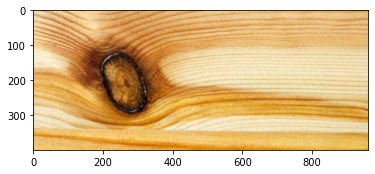

In [4]:
folder_path = './Image_data'
image_dataset = read_images_from_folder(folder_path)
plt.imshow(image_dataset[0])

In [7]:
def thresholding(image):
    image=rgb2gray(image)
    threshold_max=(image).max()
    threshold=threshold_max/2
    mask=image < threshold 
    nv_mask=binary_fill_holes(mask)
    label_image = label(nv_mask)
    regions = regionprops(label_image)
    filtered_regions = []
    for region in regions:
        if region.area > 5 and 0 <= region.eccentricity < 0.9:
            filtered_regions.append({
            'centroid': region.centroid,
            'bbox': region.bbox
            })
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.title('image avec bounding box sur les noeuds')
    ax.imshow(image,'gray')
    for region in regionprops(label_image):
        if region.area > 5 and region.eccentricity < 0.9:
             minr, minc, maxr, maxc = region.bbox

             rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
             ax.add_patch(rect)
             centroid = region.centroid
             ax.plot(centroid[1], centroid[0], 'ro', markersize=5)  
    
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    fig=plt.figure()
    plt.title('mask de binarisation ')
    plt.imshow(label_image)
    plt.show()
    return filtered_regions

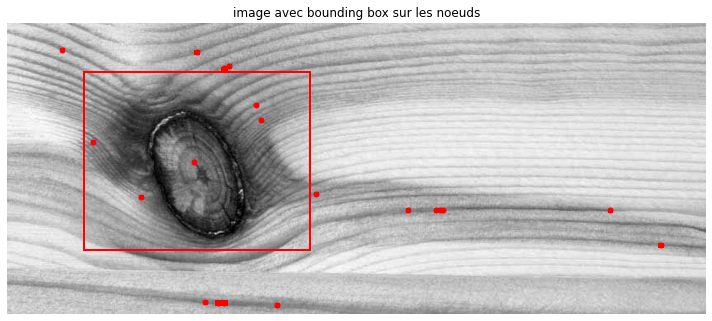

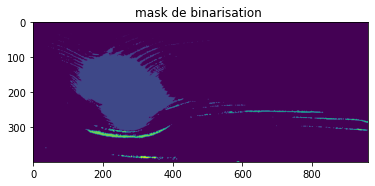

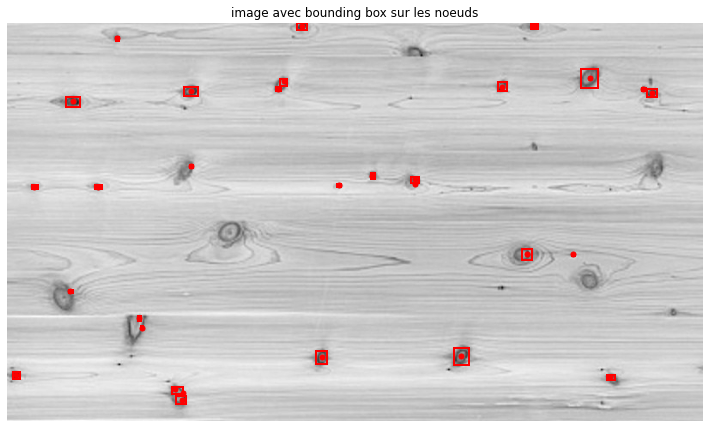

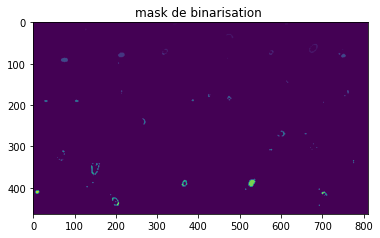

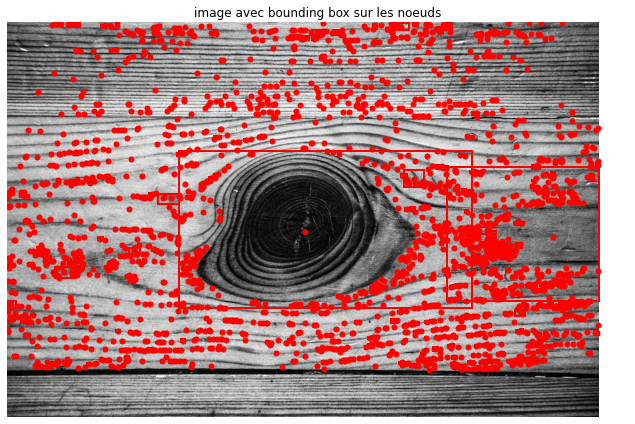

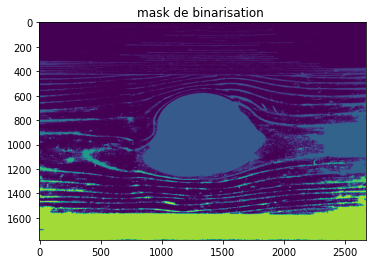

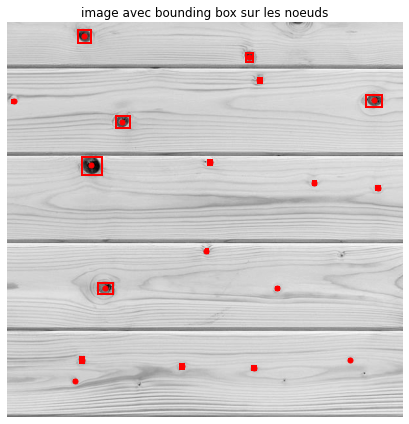

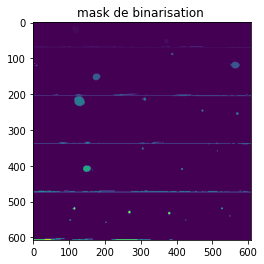

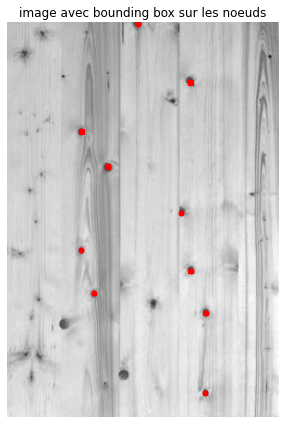

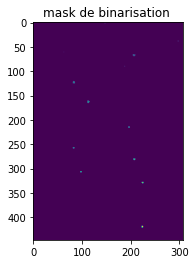

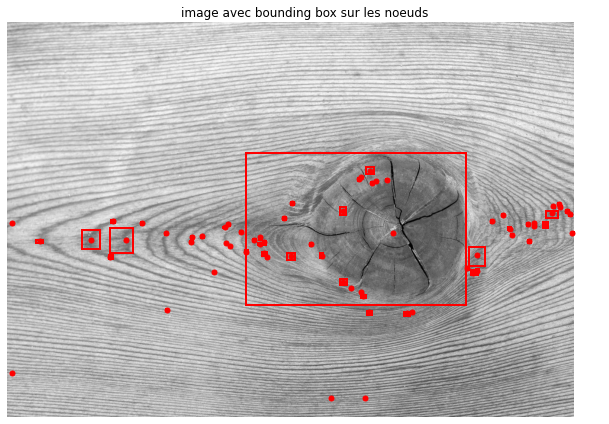

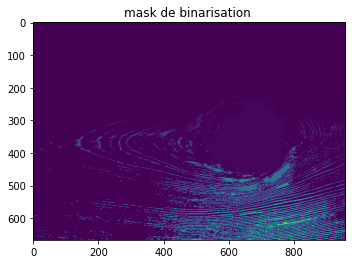

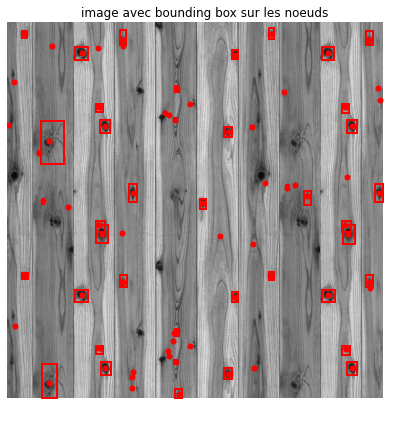

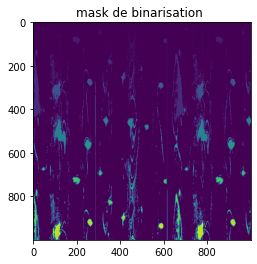

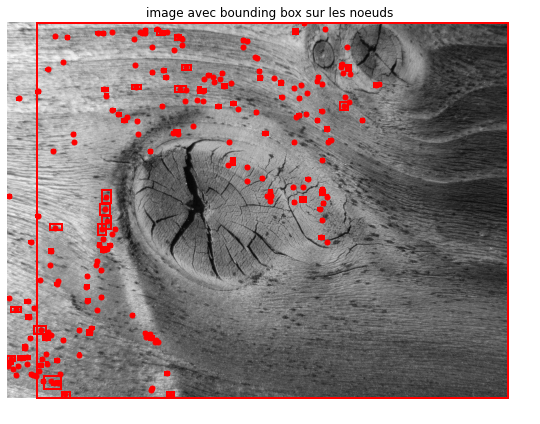

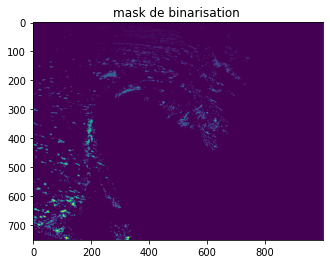

In [8]:
List_properties=[]
for i in range(len(image_dataset)):
    image=image_dataset[i]
    filtered_regionpts=thresholding(image)
    List_properties.append(filtered_regionpts)

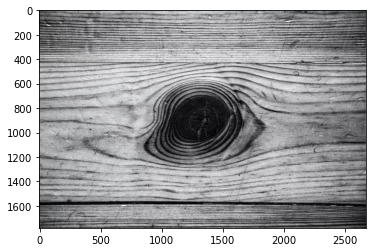

In [49]:
img=io.imread('knot_4.jpg') 

plt.imshow(img,'jet')

## Critiques :
La méthode implementée en haut procède à une segmentation directe de l'image avec la valeur t cependant cette approche ne donne pas déjà une bonne detection de tout les noeuds dans l'image ceci est liée à :

Méthode de seuillage : le suillage utilisée est une méthode simple mais pas optimale si l'éclairage et le contraste varient beaucoup --> filtrage adaptatif --> local variations
L'image 3 et l'image 8 montrent bien ce fait




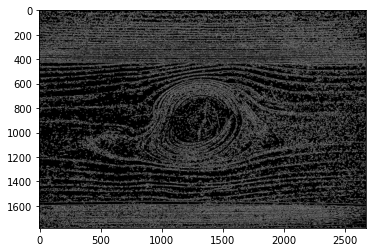

In [69]:
from skimage import feature
img=image_dataset[2]
m=sobel(img)
egdes=feature.canny(m,sigma=1)
plt.imshow(egdes,'gray')

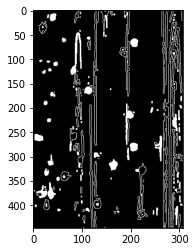

In [75]:
img=image_dataset[4]
img=gaussian(img)
m=sobel(img)
m=m>threshold_otsu(m)
egdes=feature.canny(m)
egdes=binary_fill_holes(egdes)
plt.imshow(egdes,'gray')

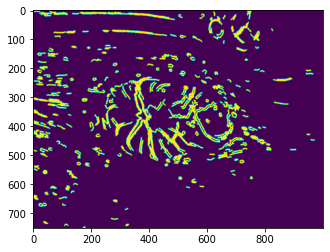

In [213]:
from skimage import feature
img=image_dataset[7]
img=gaussian(img)
img=sobel(img)

#t=threshold_otsu(img)
#mask=img > t

#watershed_image = watershed(img)
egdes=feature.canny(img)
egdes=morpho.dilation(egdes,morpho.disk(2))

plt.imshow(egdes)
#egdes=binary_fill_holes(egdes)
#label_image=label(egdes)
#dl=morpho.erosion(label_image,morpho.disk(2))



In [ ]:
mask=img<threshold_otsu(img,4)
egdes=morpho.opening(mask,morpho.disk(1))

plt.imshow(egdes)

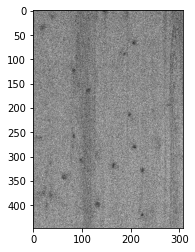

In [21]:
from skimage.util import random_noise

img=image_dataset[4]
img=rgb2gray(img)
puissance_signal=(np.linalg.norm(img,ord=None, axis=None))**2/(img.shape[0]*img.shape[1])#norme deux du vecteur signal
SNR=15
var_=puissance_signal*pow(10,-SNR/10)
image_rd=random_noise(img,mode='gaussian',var=var_,clip=False)
plt.imshow(image_rd,'gray')


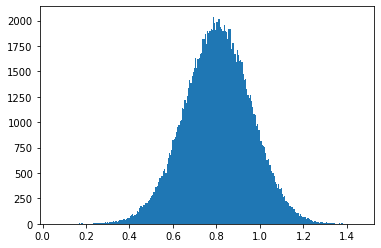

In [29]:
hist=plt.hist(image_rd.ravel(),bins=256)
plt.show()

In [39]:
List_inf=[x for x in hist[1] if x < hist[1].max()/2]
print('nombre de pixels inferieur au seuil dans le cas bruitée')
print(len(List_inf))


nombre de pixels inferieur au seuil dans le cas bruitée
123


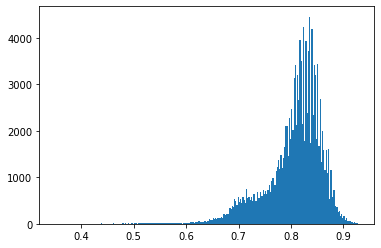

In [36]:
hist2=plt.hist(img.ravel(),bins=256)

plt.show()


In [37]:
List_inf_=[x for x in hist2[1] if x < hist2[1].max()/2]
print('le nombre de pixel inférieur au seuil sans bruitage ')
print(len(List_inf_))

52


Discussion de l'effet du bruit :

Une analyse approfondie révèle que la présence d'un bruit gaussien affecte significativement la détection des nœuds dans l'image analysée. Cette dégradation est attribuable au bruit additionnel. En effet, une comparaison quantitative entre les histogrammes de l'image originale et de l'image bruitée étaye cette observation. Pour l'image originale, l'histogramme indique que 52 pixels se situent en dessous du seuil de détection de la méthode utilisée. En revanche, pour l'image bruitée, ce nombre augmente à 123 pixels. Cette augmentation suggère que des pixels, initialement non considérés comme des nœuds, sont désormais susceptibles d'être classifiés à tort comme tels en raison de l'interférence causée par le bruit. Il est donc impératif de prendre en compte cet effet de brouillage lors de l'analyse des images sujettes à un bruit gaussien, afin de garantir la fiabilité et la précision de la détection des nœuds.

C:\Users\mouad\AppData\Local\Temp\ipykernel_20040\238347291.py:2: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image=rgb2gray(image)


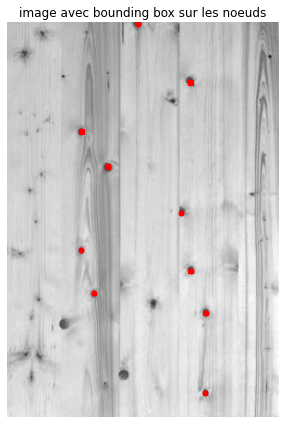

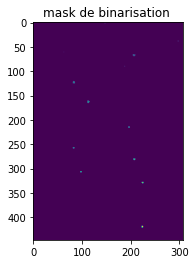

[{'centroid': (1.5, 147.5), 'bbox': (1, 146, 3, 150)},
 {'centroid': (67.41176470588235, 206.94117647058823),
  'bbox': (66, 205, 70, 210)},
 {'centroid': (123.13333333333334, 83.46666666666667),
  'bbox': (121, 82, 126, 86)},
 {'centroid': (163.0625, 113.1875), 'bbox': (161, 112, 166, 116)},
 {'centroid': (215.0, 196.71428571428572), 'bbox': (214, 196, 217, 199)},
 {'centroid': (257.5, 83.0), 'bbox': (257, 82, 259, 85)},
 {'centroid': (280.8, 207.5), 'bbox': (280, 206, 283, 210)},
 {'centroid': (306.5, 98.0), 'bbox': (306, 97, 308, 100)},
 {'centroid': (328.625, 224.75), 'bbox': (328, 223, 331, 227)},
 {'centroid': (419.2, 224.0), 'bbox': (418, 223, 422, 226)}]

In [25]:
thresholding(img)

C:\Users\mouad\AppData\Local\Temp\ipykernel_20040\238347291.py:2: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image=rgb2gray(image)


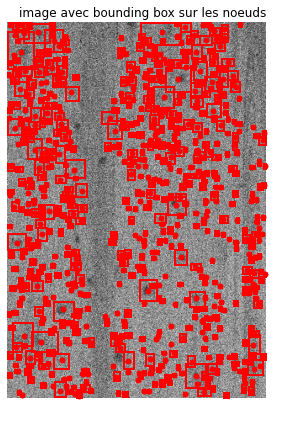

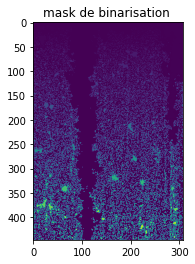

[{'centroid': (2.0, 4.0), 'bbox': (0, 2, 5, 7)},
 {'centroid': (3.5, 10.714285714285714), 'bbox': (0, 6, 8, 18)},
 {'centroid': (1.5454545454545454, 17.0), 'bbox': (0, 14, 5, 20)},
 {'centroid': (3.3333333333333335, 23.72222222222222), 'bbox': (0, 20, 7, 29)},
 {'centroid': (2.076923076923077, 52.84615384615385), 'bbox': (0, 50, 6, 56)},
 {'centroid': (10.772522522522523, 184.07207207207207),
  'bbox': (0, 159, 27, 206)},
 {'centroid': (1.5833333333333333, 201.83333333333334),
  'bbox': (0, 200, 4, 204)},
 {'centroid': (4.67741935483871, 211.80645161290323),
  'bbox': (0, 207, 11, 218)},
 {'centroid': (2.076923076923077, 233.15384615384616),
  'bbox': (0, 231, 5, 237)},
 {'centroid': (1.1111111111111112, 239.33333333333334),
  'bbox': (0, 238, 3, 242)},
 {'centroid': (1.8333333333333333, 277.1666666666667),
  'bbox': (0, 276, 5, 279)},
 {'centroid': (11.44, 36.552727272727275), 'bbox': (1, 20, 24, 50)},
 {'centroid': (5.8, 242.2), 'bbox': (3, 240, 9, 245)},
 {'centroid': (7.15384615384

In [24]:
thresholding(image_rd)

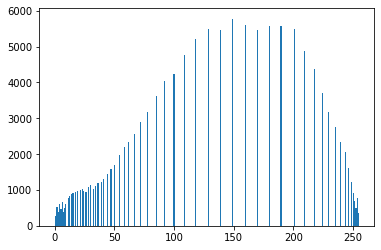

In [22]:
import cv2
image = cv2.imread('./Image_data/226360.jpg', cv2.IMREAD_GRAYSCALE)
equalized_image = cv2.equalizeHist(image)
plt.hist(equalized_image.ravel(),bins=256)
plt.show()

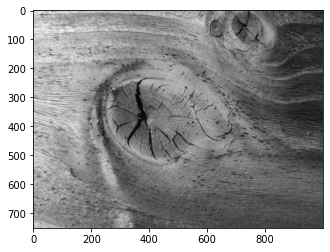

In [16]:
plt.imshow(img,'gray')

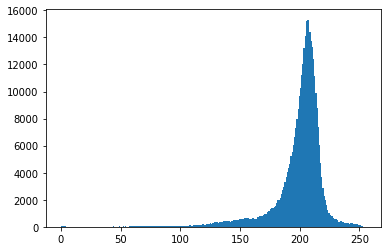

In [262]:
img_2=image_dataset[3]
plt.hist(img_2[:,:,1].ravel(),bins=256)
plt.show()

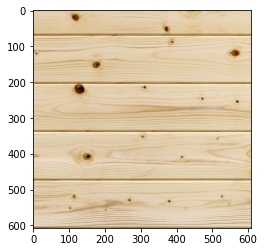

In [263]:
plt.imshow(img_2,'gray')

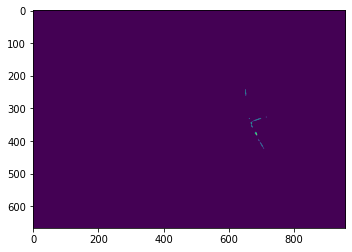

In [96]:
#mas=img_2<=0.1
mas=binary_fill_holes(mas)
plt.imshow(mas)

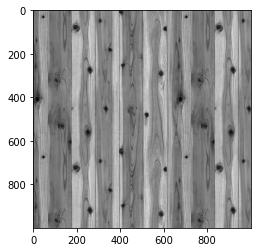

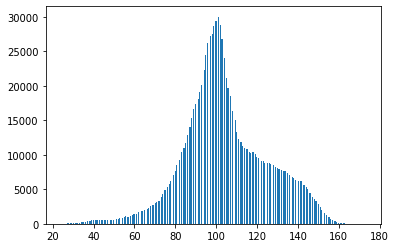

In [278]:
image=image_dataset[6]

plt.imshow(image[:,:,1],'gray')
plt.show()
plt.hist(image[:,:,1].ravel(),bins=256)
plt.show()

In [282]:
ip=abs((image[:,:,1]-image[:,:,1].mean()))/(image[:,:,1].var())

mask=image[:,:,1]< 50
dil=morpho.dilation(mask,morpho.disk(3))
#plt.imshow(ip>0.02,'gray')


array([[0.03214233, 0.03214233, 0.03214233, ..., 0.00343454, 0.00343454,
        0.00343454],
       [0.03214233, 0.03214233, 0.03214233, ..., 0.00343454, 0.00343454,
        0.00343454],
       [0.02975001, 0.02975001, 0.02975001, ..., 0.00582686, 0.00582686,
        0.00582686],
       ...,
       [0.0584578 , 0.07041938, 0.06324243, ..., 0.00343454, 0.00821917,
        0.0130038 ],
       [0.0584578 , 0.07281169, 0.06563474, ..., 0.00343454, 0.00104222,
        0.00343454],
       [0.0584578 , 0.07041938, 0.06085011, ..., 0.00821917, 0.00104222,
        0.00374241]])